In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

# Train with other sites

This notebook is used to train a modified ConvLSTM model with out of band data in order to allow it to correctly classify unknown sites. 

In [19]:
FEATURES_PATH = "data/my_20_sec_features-additional_sites-2022_07_24__17_28_44.npy"
LABELS_PATH = "data/my_20_sec_labels-additional_sites-2022_07_24__17_28_44.npy"

NAME = "out_of_band_data_test"

SEED = 42

SITES_LIST = [
    "www.amazon.co.uk",
    "www.bbc.co.uk",
    "www.ebay.co.uk",
    "www.facebook.com",
    "www.google.co.uk",
    "www.google.com",
    "www.twitter.com",
    "www.uwe.ac.uk",
    "www.wikipedia.com",
    "www.youtube.com"
    ]

In [3]:
with open(FEATURES_PATH, 'rb') as f:
    features = np.load(f)
features.shape

(3260, 200, 150, 2)

In [5]:
with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)
labels.shape

(3260,)

In [9]:
labels_cleaned = np.array([label if label in SITES_LIST else "Other" for label in labels])
labels_cleaned[:10]

array(['www.google.co.uk', 'www.bbc.co.uk', 'Other', 'www.facebook.com',
       'Other', 'www.youtube.com', 'Other', 'Other', 'Other', 'Other'],
      dtype='<U17')

In [10]:
label_binariser = LabelBinarizer()
labels_encoded = label_binariser.fit_transform(labels_cleaned)
labels_encoded.shape

(3260, 11)

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels_encoded,
    test_size=0.25,
    shuffle=True,
    random_state=SEED
)

In [12]:
max = features_train.max()

features_train = features_train/max
features_test = features_test/max

print(max)

1278.0


In [26]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10,5)) 
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')

    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss")

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')

    ax2.legend(loc="lower right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("accuracy")

    print("Final training accuracy:", history.history['accuracy'][-1])
    print("Final validation accuracy:", history.history['val_accuracy'][-1])

In [24]:
def plot_results(model):
    fig, ax = plt.subplots(figsize=(12, 12))
    y_true = np.argmax(labels_test, axis=1)
    predictions =  np.argmax(model.predict(features_test), axis=1)
    cm = confusion_matrix(y_true, predictions, normalize='true')
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[label_binariser.classes_[x] for x in range(unique_y.min(), len(unique_y))]
        )
    disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
    plt.show()
    print(classification_report(y_true, predictions))

In [16]:
def create_convlstm_model():

    model = keras.Sequential()

    model.add(layers.ConvLSTM1D(
        filters = 4,
        kernel_size=5,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True,
        input_shape = (features_train[0].shape)
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    # Dropout layer for sequence data



    model.add(layers.ConvLSTM1D(
        filters=10,
        kernel_size=15,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))


    model.add(layers.ConvLSTM1D(
        filters=14,
        kernel_size=10,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))


    model.add(layers.ConvLSTM1D(
        filters=16,
        kernel_size=10,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    # model.add(TimeDistributed(Dropout(0.2)))


    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation="relu"))
    
    model.add(layers.Dense(labels_encoded.shape[1], activation="softmax"))

    model.summary()

    return model

In [17]:
convlstm_model = create_convlstm_model()

2022-07-25 13:52:34.610175: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 200, 146, 4)       496       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 73, 4)       0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 200, 73, 4)       0         
 ibuted)                                                         
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 200, 59, 10)       8440      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 200, 30, 10)      0         
 2D)                                                             
                                                        

In [18]:
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

In [20]:
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
convlstm_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=16, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
123/123 [==============================] - 360s 3s/step - loss: 2.2167 - accuracy: 0.3354 - val_loss: 2.2464 - val_accuracy: 0.2924
Epoch 2/50
123/123 [==============================] - 351s 3s/step - loss: 2.1807 - accuracy: 0.3374 - val_loss: 2.2383 - val_accuracy: 0.2924
Epoch 3/50
123/123 [==============================] - 340s 3s/step - loss: 2.1792 - accuracy: 0.3374 - val_loss: 2.2465 - val_accuracy: 0.2924
Epoch 4/50
123/123 [==============================] - 336s 3s/step - loss: 2.1726 - accuracy: 0.3374 - val_loss: 2.2706 - val_accuracy: 0.2924
Epoch 5/50
123/123 [==============================] - 333s 3s/step - loss: 2.0958 - accuracy: 0.3563 - val_loss: 1.9848 - val_accuracy: 0.3497
Epoch 6/50
123/123 [==============================] - 336s 3s/step - loss: 1.8460 - accuracy: 0.3896 - val_loss: 1.7972 - val_accuracy: 0.3476
Epoch 7/50
123/123 [==============================] - 396s 3s/step - loss: 1.4608 - accuracy: 0.4473 - val_loss: 1.3254 - val_accuracy: 0.4969

In [15]:
y_true = np.argmax(labels_test, axis=1)
unique_y = np.unique(y_true)

Final training accuracy: 0.9274028539657593
Final validation accuracy: 0.9059304594993591


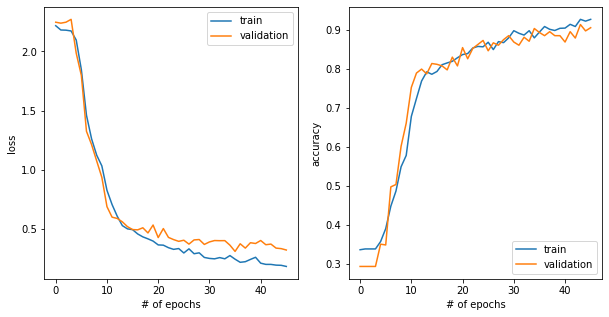

In [27]:
plot_history(convlstm_history)

In [22]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
loss, acc = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_datetime = dt.datetime.now()
current_datetime_string = dt.datetime.strftime(current_datetime, date_time_format)
model_file_name =f"convlstm_model_{NAME}_Datetime_{current_datetime_string}__loss_{loss}_acc_{acc}.h5"
convlstm_model.save(os.path.join("models", model_file_name))

26/26 [==============================] - 9s 339ms/step - loss: 0.3249 - accuracy: 0.8712


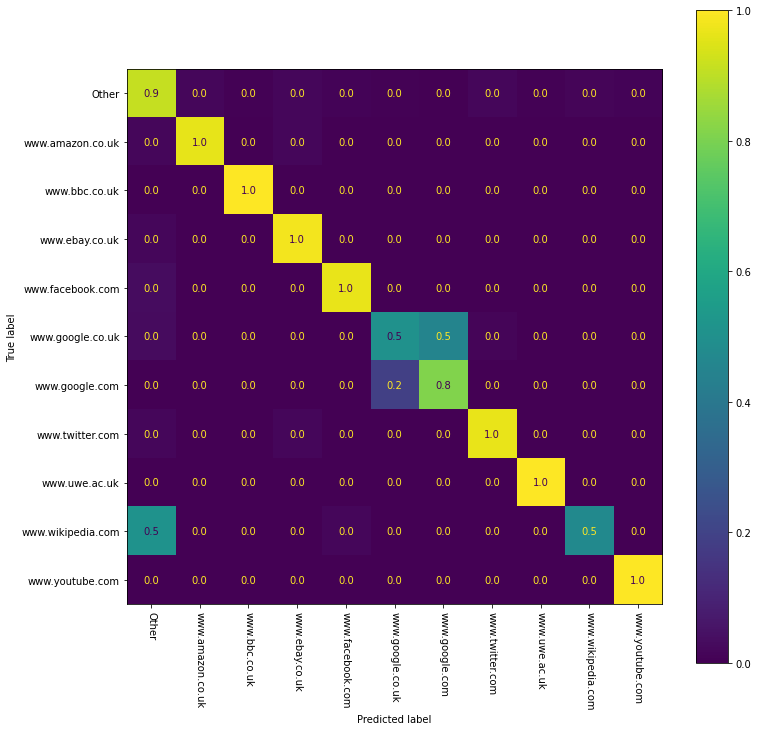

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       251
           1       0.93      0.96      0.95        56
           2       0.98      1.00      0.99        47
           3       0.89      0.98      0.94        52
           4       0.95      0.97      0.96        59
           5       0.77      0.51      0.61        71
           6       0.57      0.81      0.67        53
           7       0.92      0.97      0.94        61
           8       0.98      1.00      0.99        55
           9       0.90      0.47      0.62        59
          10       0.96      1.00      0.98        51

    accuracy                           0.87       815
   macro avg       0.88      0.87      0.87       815
weighted avg       0.88      0.87      0.86       815



In [25]:
plot_results(convlstm_model)